In [3]:
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *
from fastai.vision.widgets import *

In [6]:
key = os.environ.get('AZURE_SEARCH_KEY', 'f141c91912c1411eaebaa48cbeeb3eac')

In [7]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [8]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [9]:
ims

(#150) ['https://d.newsweek.com/en/full/1838751/grizzly-bear.jpg?w=790&f=aeeaa14774fe0e3e5a8735dfb379f0ab','https://ewscripps.brightspotcdn.com/dims4/default/2590995/2147483647/strip/true/crop/3000x1688+0+192/resize/1280x720!/quality/90/?url=https:%2F%2Fewscripps.brightspotcdn.com%2F50%2F1b%2F3a8e35244963be2680f0c6308eb0%2Fgrizzlybear.jpg','https://e3.365dm.com/21/07/2048x1152/skynews-grizzly-bear-file_5439223.jpg?20210706175041','https://images.latintimes.com/sites/latintimes.com/files/styles/large/public/2020/12/06/grizzly-bear.jpg','https://1471793142.rsc.cdn77.org/data/images/full/54854/grizzly-bear.jpg?w=594?w=650','https://newsflash.one/wp-content/uploads/2021/07/1625628867_210706-grizzly-bear-jm-2213.jpg','https://nypost.com/wp-content/uploads/sites/2/2021/07/grizzly-bear.jpg?quality=90&strip=all&w=1200','https://ewscripps.brightspotcdn.com/dims4/default/bb6ef91/2147483647/strip/true/crop/4032x2268+0+378/resize/1280x720!/quality/90/?url=https:%2F%2Fewscripps.brightspotcdn.com%2F

In [10]:
import os
os.mkdir('images')

FileExistsError: [Errno 17] File exists: 'images'

In [11]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)
dest

'images/grizzly.jpg'

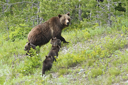

In [12]:
im = Image.open(dest)
im.to_thumb(128,128)

In [13]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [14]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [15]:
fns = get_image_files(path)
fns

(#370) [Path('bears/grizzly/00000038.jpg'),Path('bears/grizzly/00000010.jpg'),Path('bears/grizzly/00000037.jpeg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000011.jpg'),Path('bears/grizzly/00000039.jpg'),Path('bears/grizzly/00000007.JPG'),Path('bears/grizzly/00000012.jpg'),Path('bears/grizzly/00000016.jpg'),Path('bears/grizzly/00000003.jpg')...]

In [16]:
failed = verify_images(fns)
failed

/Users/darchcruise/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/Users/darchcruise/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/Users/darchcruise/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#10) [Path('bears/grizzly/00000113.jpg'),Path('bears/grizzly/00000118.jpg'),Path('bears/grizzly/00000097.jpg'),Path('bears/black/00000003.png'),Path('bears/black/00000149.jpg'),Path('bears/black/00000026.jpg'),Path('bears/teddy/00000012.jpg'),Path('bears/teddy/00000132.jpg'),Path('bears/teddy/00000122.jpg'),Path('bears/teddy/00000036.jpg')]

In [17]:
failed.map(Path.unlink);

In [18]:
??verify_images

In [19]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

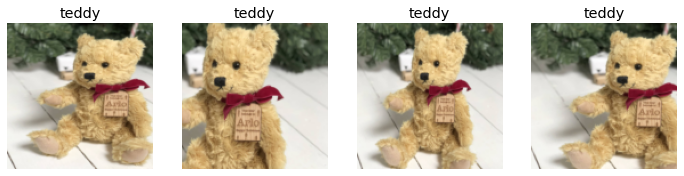

In [20]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/Users/darchcruise/opt/anaconda3/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


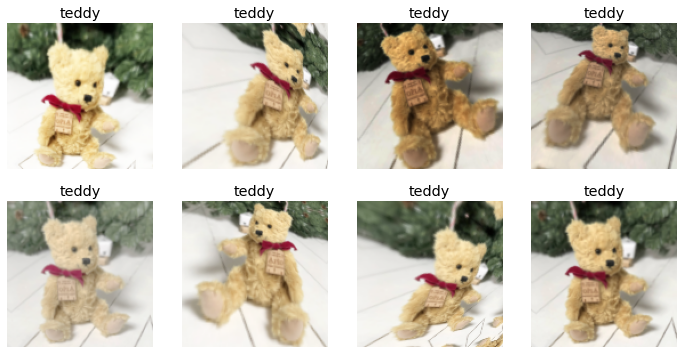

In [21]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [24]:
dls

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time


/Users/darchcruise/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [6]:
learn_inf = load_learner('/Users/darchcruise/Desktop/learn_fastai/export.pkl')

In [62]:
learn_inf.predict('images/teddy1.jpg')

('human', tensor(2), tensor([1.2887e-06, 3.8657e-05, 6.0057e-01, 3.9939e-01]))

In [27]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [50]:
#btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])
btn_upload = SimpleNamespace(data = ['images/teddy1.jpg'])

In [51]:
img = PILImage.create(btn_upload.data[-1])

In [52]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [55]:
pred,pred_idx,probs = learn_inf.predict(img)

In [54]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: human; Probability: 0.6006')

In [56]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [57]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [58]:
btn_upload = widgets.FileUpload()

In [59]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [64]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 551 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 416 kB 14.5 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Attempting uninstall: tornado
    Found existing installation: tornado 6.0.4
    Uninstalling tornado-6.0.4:
      Successfully uninstalled tornado-6.0.4
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spyder 4.1.5 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.1.5 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
nbdev 1.1.14 requires nbconvert<6, but you'll have nbconvert 6.1.0 which is in